In [14]:
##### IMPORTING DEPENDENCIES #####
# system tools and parse
import os 
import argparse
import warnings
warnings.filterwarnings("ignore")
# data tools
import pandas as pd
# tf tools
import tensorflow as tf
# image processsing
from tensorflow.keras.preprocessing.image import (ImageDataGenerator)
# VGG16 model
from tensorflow.keras.applications.vgg16 import VGG16
# layers
from tensorflow.keras.layers import (Dense, Flatten, BatchNormalization)
# generic model object
from tensorflow.keras.models import Model, Sequential
# optimizers
from tensorflow.keras.optimizers import Adam, SGD
#scikit-learn
from sklearn.metrics import classification_report
import sklearn.model_selection as sk
# for plotting
import numpy as np
import matplotlib.pyplot as plt


In [15]:
# import splitfolders

# splitfolders.ratio("fruits/train/train/", # The location of dataset
#                    output="fruits_v2", # The output location
#                    seed=42, # The number of seed
#                    ratio=(.7, .2, .1), # The ratio of splited dataset
#                    group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
#                    move=False # If you choose to move, turn this into True
#                    )

In [16]:
img_size = (100, 100)

In [17]:
def setup_generators():
    # Parameters for loading data and images

    train_generator = ImageDataGenerator(horizontal_flip=True,
                                         rescale = 1./255,
                                         validation_split=0.2
                                         )
    
    test_generator = ImageDataGenerator(rescale=1./255)
    
    return train_generator, test_generator

train_generator, test_generator = setup_generators()

In [18]:
def setup_data(train_generator, test_generator):
    # Split the data into three categories.
    train_ds = train_generator.flow_from_directory(
        directory=os.path.join(os.getcwd(), "fruits_v2", "train"),
        target_size=img_size,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=42
    )
    
    val_ds = train_generator.flow_from_directory(
        directory=os.path.join(os.getcwd(), "fruits_v2", "val"),
        target_size=img_size,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=42
    )

    test_ds = test_generator.flow_from_directory(
        directory=os.path.join(os.getcwd(), "fruits_v2", "test"),
        target_size=img_size,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = setup_data(train_generator, test_generator)

Found 11787 images belonging to 33 classes.
Found 3361 images belonging to 33 classes.
Found 1706 images belonging to 33 classes.


In [37]:
def simple_model_setup():
    
    tf.keras.backend.clear_session()
    # Define the model architecture
    simple_model = Sequential()
    simple_model.add(Flatten(input_shape=(img_size[0], img_size[1], 3)))
    simple_model.add(Dense(33, activation='softmax'))

    # Compile the model
    simple_model.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=0.001),
                metrics=['accuracy'])

    print(simple_model.summary())
    
    return simple_model

simple_model = simple_model_setup()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 30000)             0         
                                                                 
 dense (Dense)               (None, 33)                990033    
                                                                 
Total params: 990,033
Trainable params: 990,033
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
def model_setup():

    tf.keras.backend.clear_session()
    
    # load model without classifier layers
    model = VGG16(include_top=False, 
                pooling="avg",
                input_shape=(img_size[0], img_size[1], 3),
                weights='imagenet')

    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    
    x = Flatten()(model.layers[-1].output)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(33, activation='softmax')(x)

    model = Model(inputs=model.inputs, outputs=outputs)

    # compile
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01,
        decay_steps=10000,
        decay_rate=0.9)
    
    sgd = SGD(learning_rate=lr_schedule)

    model.compile(optimizer=sgd,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
    print(model.summary())
    
    return model

model = model_setup()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [38]:
def train_model(model, train_ds, val_ds):
    
    # Define the EarlyStopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    restore_best_weights=True)
    
    history = model.fit_generator(train_ds,
                        validation_data = val_ds,
                        epochs=100,
                        callbacks=[early_stopping]
                        )
    
    return history

In [47]:
history = train_model(model, train_ds, val_ds)

Epoch 1/100
146/369 [==========>...................] - ETA: 3:45 - loss: 2.5043 - accuracy: 0.4107

KeyboardInterrupt: 

In [39]:
history_simple = train_model(simple_model, train_ds, val_ds)

Epoch 1/100
369/369 [==============================] - 20s 52ms/step - loss: 3.4337 - accuracy: 0.6997 - val_loss: 1.0149 - val_accuracy: 0.8578
Epoch 2/100
369/369 [==============================] - 18s 49ms/step - loss: 0.9184 - accuracy: 0.8548 - val_loss: 0.2653 - val_accuracy: 0.9461
Epoch 3/100
369/369 [==============================] - 18s 50ms/step - loss: 0.4704 - accuracy: 0.9175 - val_loss: 0.3391 - val_accuracy: 0.9223
Epoch 4/100
369/369 [==============================] - 28s 76ms/step - loss: 0.4763 - accuracy: 0.9241 - val_loss: 0.3951 - val_accuracy: 0.9197
Epoch 5/100
369/369 [==============================] - 26s 71ms/step - loss: 0.5167 - accuracy: 0.9255 - val_loss: 0.1179 - val_accuracy: 0.9708
Epoch 6/100
369/369 [==============================] - 38s 102ms/step - loss: 0.4770 - accuracy: 0.9452 - val_loss: 0.4389 - val_accuracy: 0.9586
Epoch 7/100
369/369 [==============================] - 35s 95ms/step - loss: 0.7095 - accuracy: 0.9292 - val_loss: 0.3112 - val_a

In [42]:
##### PLOTTING FUNCTION #####
def plot_history(H, epochs):
    plt.style.use("seaborn-colorblind")

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss", linestyle=":")
    plt.title("Loss curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc", linestyle=":")
    plt.title("Accuracy curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.legend()
    plt.savefig(os.path.join(os.getcwd(), "out", "simple_classification.png"))

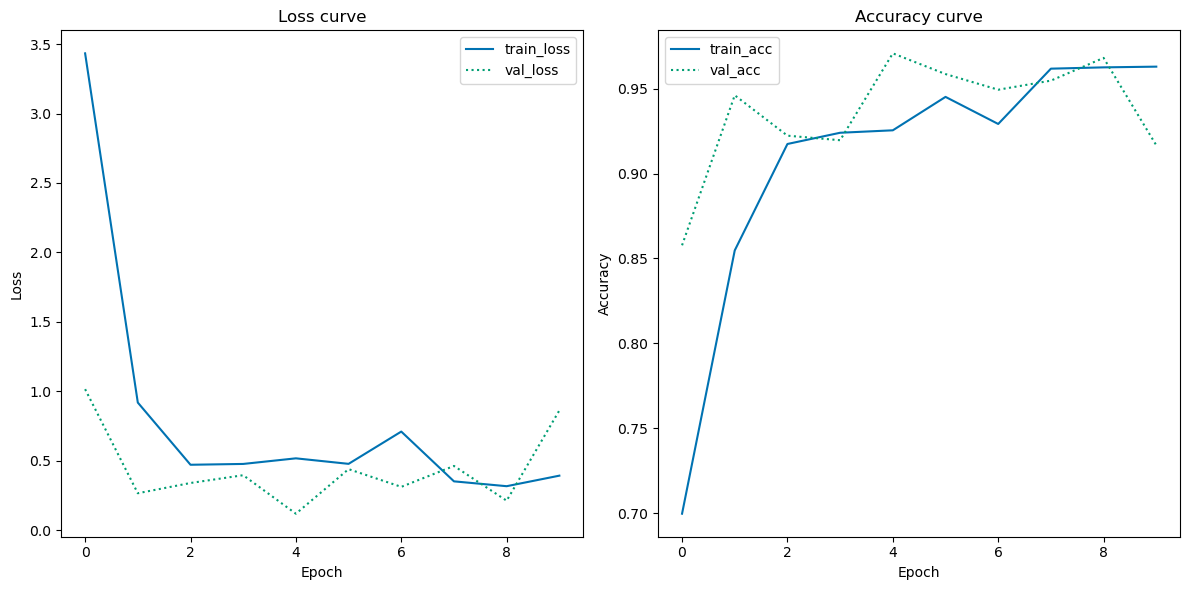

In [43]:
plot_history(history_simple, 10)

In [44]:
def make_predictions(model, test_ds):
    y_test = test_ds.classes

    y_predictions = model.predict_generator(test_ds, steps=len(test_ds))

    y_pred = np.argmax(y_predictions, axis=1)
    
    return y_test, y_predictions, y_pred

def print_report(y_test, y_pred, test_ds):
    # Get the classification report
    report = classification_report(y_test,
                                   y_pred,
                                   target_names = test_ds.class_indices.keys()
                                   )
    # Save the report
    with open(os.path.join(os.getcwd(), "out", "classification_report.txt"), "w") as f:
            f.write(report)
    # Print the report
    print(report)

In [45]:
y_test, y_predictions, y_pred = make_predictions(simple_model, test_ds)

In [46]:
print_report(y_test, y_pred, test_ds)

                    precision    recall  f1-score   support

    Apple Braeburn       0.93      1.00      0.96        50
Apple Granny Smith       1.00      0.98      0.99        50
           Apricot       1.00      1.00      1.00        50
           Avocado       1.00      1.00      1.00        44
            Banana       1.00      1.00      1.00        49
         Blueberry       1.00      0.98      0.99        47
      Cactus fruit       1.00      0.92      0.96        49
        Cantaloupe       1.00      1.00      1.00        50
            Cherry       1.00      0.98      0.99        50
        Clementine       1.00      1.00      1.00        49
              Corn       1.00      1.00      1.00        45
     Cucumber Ripe       1.00      0.88      0.93        40
        Grape Blue       0.99      1.00      1.00       100
              Kiwi       1.00      1.00      1.00        47
             Lemon       1.00      1.00      1.00        50
             Limes       0.94      1.00